# Visualising molecules and computing properties in RDKit

In [2]:
#Import useful modules and packages:

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")

I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


Visualise a single molecule:

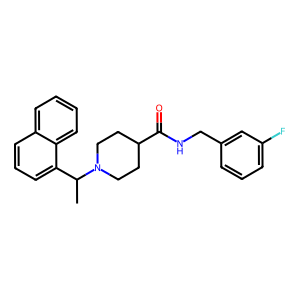

In [3]:
q= Chem.MolFromSmiles("Fc8cccc(c8)CNC(=O)C3CCN(C(c1c2ccccc2ccc1)C)CC3")
Draw.MolToImage(q)

Or simply:

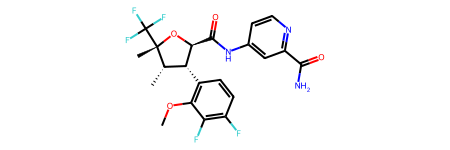

In [4]:
Chem.MolFromSmiles("C[C@H]1[C@H]([C@@H](O[C@@]1(C)C(F)(F)F)C(=O)NC2=CC(=NC=C2)C(=O)N)C3=C(C(=C(C=C3)F)F)OC")

And this is how we visualise molecules in a grid:

In [5]:
# First we create some example smiles and put them in a dataframe:

smi = {'smiles': ['c1ccccc1C(=O)O', 'c1ccccc1N', 'c1ccccc1O', 'c1ccccc1ON']}
da = pd.DataFrame(data=smi)
da['mol'] = da['smiles'].apply(Chem.MolFromSmiles)
da


,smiles,mol
0,c1ccccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x13352bae0>
1,c1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x13352bb50>
2,c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x13352bbc0>
3,c1ccccc1ON,<rdkit.Chem.rdchem.Mol object at 0x13352bc30>


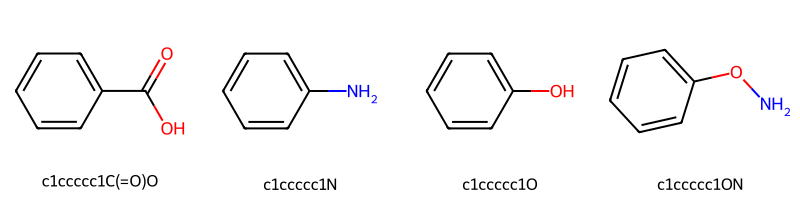

In [6]:
# Now we visualise them with legends:

Draw.MolsToGridImage(da.mol, molsPerRow=4, legends=list(da['smiles']))

Now, Compute some commonly used molecular descriptors:

In [7]:
x1 = Chem.MolFromSmiles('C[C@H]1[C@H]([C@@H](O[C@@]1(C)C(F)(F)F)C(=O)NC2=CC(=NC=C2)C(=O)N)C3=C(C(=C(C=C3)F)F)OC')

print('Mol-Wt:', Descriptors.ExactMolWt(x1))
print('TPSA:', Descriptors.TPSA(x1))
print('LogP:', Descriptors.MolLogP(x1))
print('Rot_bonds:', Descriptors.NumRotatableBonds(x1)) #without hydrogens is the valid count for RB
print('HBA:', Descriptors.NumHAcceptors(x1))
print('HBD:', Descriptors.NumHDonors(x1))

Mol-Wt: 473.13739721999997
TPSA: 103.53999999999999
LogP: 3.5455000000000014
Rot_bonds: 5
HBA: 5
HBD: 2


Now, we will compute all descriptors that can be calculated in RDKit. This can be very useful for model building and molecule filtering:

In [8]:
descrs = Descriptors.CalcMolDescriptors(x1)

print(f"This returns around {len(descrs)} descriptors, inside a {type(descrs)}")

This returns around 210 descriptors, inside a <class 'dict'>


The dictionary in return could be converted into a Pandas dataframe:

In [9]:
#Display top 3 items:
pd.DataFrame(descrs.items()).head(3)

,0,1
0,MaxAbsEStateIndex,14.350342
1,MaxEStateIndex,14.350342
2,MinAbsEStateIndex,0.024691


However, most of the times, we wish to compute descriptors inside a dataframe for a bunch of molecules.

So here's how we do this:

In [10]:
# Import a sample dataframe containing SMILES molecules:

data = pd.read_csv("data/CS12_combined.csv")
print(f"The dataframe contains {data.shape[0]} molecules")
data.head(3)

The dataframe contains 999 molecules


,ID,SMILES,QED,Retrosynthesis Score,Retrosynthesis Steps
0,1,CCCc1ncnc(-c2ccc(C(=O)N3CCN(C(C)CC)CC3)c(F)c2)...,0.511405,0.6,5.0
1,2,CCc1ncnc(-c2ccc(C(=O)N3CCN(C(C)C)CC3)c(F)c2)c1...,0.585936,0.2,2.0
2,3,CC(C)Cc1ncnc(-c2ccc(C(=O)N3CCN(C(C)C)CC3)c(F)c...,0.532574,0.6,7.0


In [11]:
#Now we compute a mol object:

data['mol'] = data.SMILES.apply(Chem.MolFromSmiles)

In [12]:
#Compute descriptors for all molecules:
allDescrs = [Descriptors.CalcMolDescriptors(m) for m in data['mol']]

In [13]:
#Convert the above dictionary to dataframe:
df = pd.DataFrame(allDescrs)

#check size  of the dataframe:
print(df.shape)

#check how the dataframe looks like:
df.head()

(999, 210)


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,15.312143,15.312143,0.073297,-0.565599,0.511405,14.648649,500.622,467.358,500.269988,192,...,0,0,0,0,0,0,0,0,0,0
1,15.191383,15.191383,0.066760,-0.572136,0.585936,14.028571,472.568,443.336,472.238688,180,...,0,0,0,0,0,0,0,0,0,0
2,15.319614,15.319614,0.068324,-0.569949,0.532574,14.081081,500.622,467.358,500.269988,192,...,0,0,0,0,0,0,0,0,0,0
3,13.088903,13.088903,0.076993,0.076993,0.575435,14.771429,468.605,436.349,468.263760,180,...,0,0,0,0,0,0,0,0,0,0
4,15.291769,15.291769,0.073297,-0.567051,0.511405,14.648649,500.622,467.358,500.269988,192,...,0,0,0,0,0,0,0,0,0,0


But we see that this dataframe only has descriptors. Hence we concatenate the 'data' dataframe to the one above:

In [14]:
all_df = pd.concat([data, df], axis=1)

In [15]:
all_df.head(3)

,ID,SMILES,QED,Retrosynthesis Score,Retrosynthesis Steps,mol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,CCCc1ncnc(-c2ccc(C(=O)N3CCN(C(C)CC)CC3)c(F)c2)...,0.511405,0.6,5.0,<rdkit.Chem.rdchem.Mol object at 0x133665690>,15.312143,15.312143,0.073297,-0.565599,...,0,0,0,0,0,0,0,0,0,0
1,2,CCc1ncnc(-c2ccc(C(=O)N3CCN(C(C)C)CC3)c(F)c2)c1...,0.585936,0.2,2.0,<rdkit.Chem.rdchem.Mol object at 0x133665700>,15.191383,15.191383,0.066760,-0.572136,...,0,0,0,0,0,0,0,0,0,0
2,3,CC(C)Cc1ncnc(-c2ccc(C(=O)N3CCN(C(C)C)CC3)c(F)c...,0.532574,0.6,7.0,<rdkit.Chem.rdchem.Mol object at 0x133665770>,15.319614,15.319614,0.068324,-0.569949,...,0,0,0,0,0,0,0,0,0,0
